          idd                                              title  \
0  Fq+C96tcx+  ‘A target on Roe v. Wade ’: Oklahoma bill maki...   
1  bHUqK!pgmv  Study: women had to drive 4 times farther afte...   
2  4Y4Ubf%aTi        Trump, Clinton clash in dueling DC speeches   
3  _CoY89SJ@K  Grand jury in Texas indicts activists behind P...   
4  +rJHoRQVLe  As Reproductive Rights Hang In The Balance, De...   

                                                text label  
0  UPDATE: Gov. Fallin vetoed the bill on Friday....  REAL  
1  Ever since Texas laws closed about half of the...  REAL  
2  Donald Trump and Hillary Clinton, now at the s...  REAL  
3  A Houston grand jury investigating criminal al...  REAL  
4  WASHINGTON -- Forty-three years after the Supr...  REAL  

Missing values:
 idd      0
title    1
text     0
label    0
dtype: int64

✅ Accuracy: 0.9249183895538629

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89   

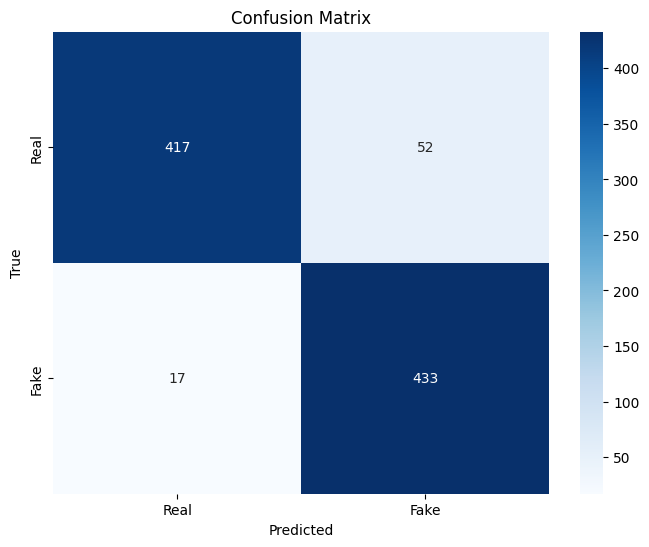


Top predictive features:
           feature  importance
3924          said    4.987315
54            2016    3.219129
3950       sanders    3.190457
2130       hillary    2.953771
3061       october    2.794522
1147          cruz    2.781610
4619         trump    2.666851
3756    republican    2.507201
702     candidates    2.327444
680       campaign    2.324690
3912        russia    2.223066
4815        voters    2.161781
397        article    2.116909
1200        debate    2.047263
4258         state    2.031673
859        clinton    1.993534
1008  conservative    1.911582
3406     president    1.894164
1991           gop    1.835174
4882           web    1.810501


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('fake_and_real_news_dataset.csv')

# Check the data
print(df.head())
print("\nMissing values:\n", df.isnull().sum())

# Remove missing values
df = df.dropna()

# Prepare data
X = df['text']
y = df['label']

# Convert labels to binary (Note: you have inconsistent mappings in your code)
# In the first part you used FAKE=1, REAL=0, but in the second part it's reversed
# Let's use FAKE=1, REAL=0 consistently
if not pd.api.types.is_numeric_dtype(y):
    y = y.map({'FAKE': 1, 'fake': 1, 'REAL': 0, 'real': 0})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data
# Combining the best of both your vectorizer configurations
vectorizer = TfidfVectorizer(
    max_features=5000, 
    stop_words='english',
    max_df=0.7,  # Ignore terms appearing in >70% documents
    ngram_range=(1, 2)  # Use 1-word and 2-word phrases
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Create and train the model
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_vec, y_train)

# Make predictions
y_pred = model.predict(X_test_vec)

# Evaluate the model
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'],  # Since 0=Real, 1=Fake based on your mapping
            yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Show the most important features
feature_importance = pd.DataFrame({
    'feature': vectorizer.get_feature_names_out(),
    'importance': np.abs(model.coef_[0])
})
top_features = feature_importance.sort_values('importance', ascending=False).head(20)
print("\nTop predictive features:")
print(top_features)

In [2]:
import joblib
import os

# Create directory for models
os.makedirs('backend/models', exist_ok=True)

# Save model and vectorizer
joblib.dump(model, 'backend/models/fake_news_model.pkl')
joblib.dump(vectorizer, 'backend/models/vectorizer.pkl')
print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


In [3]:
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?:\/\/\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)           # Remove HTML tags
    text = re.sub(r'\d+', '', text)             # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra spaces
    return text

# Apply cleaning
X = X.apply(clean_text)


In [4]:
vectorizer = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    max_df=0.7,
    min_df=5,
    ngram_range=(1, 2),
    sublinear_tf=True
)


In [5]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=42)


In [6]:
misclassified = X_test[y_test != y_pred]
print("\nSample Misclassified Articles:")
print(misclassified.head(5))



Sample Misclassified Articles:
23      What do you think the response would be if a b...
4590    Print \nSen. Bernie Sanders laid out the ways ...
26      (CNN) The contamination of drinking water in F...
915     His wife, Melania, and 10-year-old son, Barron...
1794    Radio host Sean Hannity said on his show Wedne...
Name: text, dtype: object


In [7]:
import joblib
joblib.dump(model, 'backend/models/fake_news_model.pkl')
joblib.dump(vectorizer, 'backend/models/vectorizer.pkl')


['backend/models/vectorizer.pkl']

In [8]:
from transformers import DistilBertTokenizer
from sklearn.model_selection import train_test_split

# Labels must be int type (0 = real, 1 = fake)
df['label'] = df['label'].map({'REAL': 0, 'FAKE': 1})

# Clean text (reusing previous logic if needed)
df['text'] = df['text'].str.lower().str.strip()

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)


c:\Users\jaise\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import torch

class FakeNewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)


In [10]:
import accelerate
print(accelerate.__version__)


1.6.0


In [11]:
from transformers import DistilBertForSequenceClassification


In [12]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1
)


In [20]:
from transformers import TrainingArguments

# Load pre-trained model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Training arguments


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1
)




# Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.724400
20,0.666400
30,0.549300
40,0.376400
50,0.310500
60,0.676400
70,0.482800
80,0.229200
90,0.331800
100,0.697700


TrainOutput(global_step=919, training_loss=0.23920252068339157, metrics={'train_runtime': 4193.322, 'train_samples_per_second': 0.876, 'train_steps_per_second': 0.219, 'total_flos': 486685222662144.0, 'train_loss': 0.23920252068339157, 'epoch': 1.0})

In [21]:
import pandas as pd

# Load the dataset again
df = pd.read_csv("backend/data/fake_and_real_news_dataset.csv")


# Map labels (FAKE = 1, REAL = 0)
df['label'] = df['label'].map({'REAL': 0, 'FAKE': 1})

# Optional: Basic text cleaning (you can skip if already lowercase)
df['text'] = df['text'].str.lower().str.strip()

# Split into train/test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)


In [22]:
# Evaluate the model
results = trainer.evaluate()
print("📊 Evaluation Results:", results)

# Save model and tokenizer
model.save_pretrained("backend/models/bert_fakenews_model")
tokenizer.save_pretrained("backend/models/bert_fakenews_model")


📊 Evaluation Results: {'eval_loss': 0.1604098379611969, 'eval_runtime': 380.3891, 'eval_samples_per_second': 2.416, 'eval_steps_per_second': 0.605, 'epoch': 1.0}


('backend/models/bert_fakenews_model\\tokenizer_config.json',
 'backend/models/bert_fakenews_model\\special_tokens_map.json',
 'backend/models/bert_fakenews_model\\vocab.txt',
 'backend/models/bert_fakenews_model\\added_tokens.json')

In [23]:
model.save_pretrained("backend/models/bert_fakenews_model")
